# XO-1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [3]:
name = 'XO-1'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))
print(len(fnames))

129


In [5]:
obs = om.Observation.from_files(fnames)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/it]


In [7]:
sr = lk.search_lightcurve(name, author='SPOC', exptime=120, mission='tess')
clc = sr.download_all().stitch().remove_nans()
tmask = np.asarray([~clc.to_periodogram('bls', period=[p, p], duration=dur).get_transit_mask(period=p, duration=dur, transit_time=t0) for p, t0, dur in zip(obs.period, obs.t0 - 2457000, 1.5 * obs.duration/24)]).all(axis=0)
nb = int(0.2/np.median(np.diff(clc.time.value)))
clc = clc.flatten(nb if nb % 2 == 1 else nb + 1, mask=~tmask, sigma=5)

In [8]:
# import lightkurve as lk
# import astropy.units as u

# clc = lk.search_lightcurve('GJ9827', mission='K2', author='EVEREST').download().remove_nans()
# clc.time += 2454833

# tmask = np.asarray([~clc.to_periodogram('bls', period=[p, p], duration=dur).get_transit_mask(period=p, duration=dur, transit_time=t0) for p, t0, dur in zip(obs.period, obs.t0, 1.5 * obs.duration/24)]).all(axis=0)
# nb = int(0.2/np.median(np.diff(clc.time.value)))
# clc = clc.flatten(nb if nb % 2 == 1 else nb + 1, mask=~tmask, sigma=5)

# clc.flux_err = clc.fraw_err.value/clc.fraw.value.mean()

In [9]:
obs.fit_transit(x_suppl=clc.time.value,
                y_suppl=clc.flux.value,
                yerr_suppl=clc.flux_err.value, fit_t0=True, fit_period=True, ttvs=False, calc_eclipse=False)

optimizing logp for variables: [r_suppl, b, r, m_star, r_star, u, u_suppl, period, t0, y_supplmean]


message: Desired error not necessarily achieved due to precision loss.
logp: 51600.145128041084 -> 80070.94918074532
optimizing logp for variables: [r_suppl, b, r, m_star, r_star, u, u_suppl, period, t0, y_supplmean]


message: Desired error not necessarily achieved due to precision loss.
logp: 80458.70629836833 -> 80460.75266553172


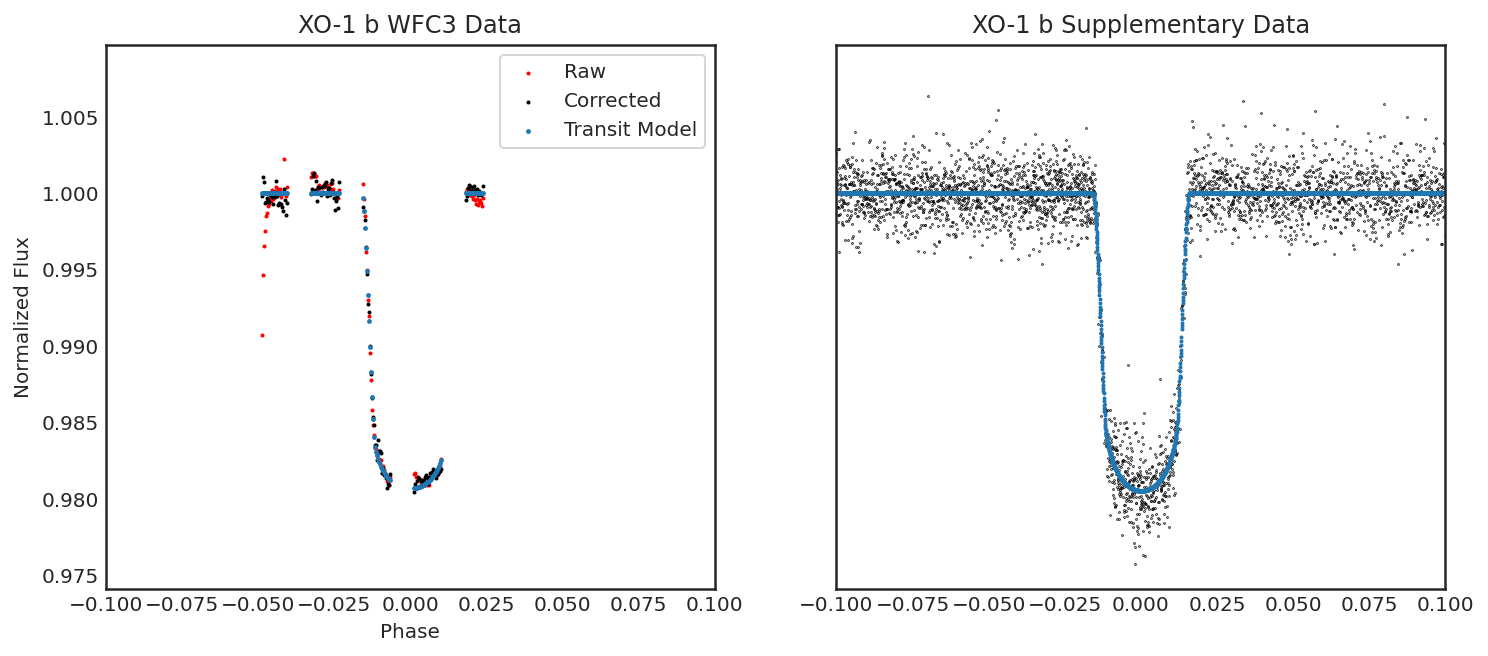

In [22]:
obs.plot_transit_fit(xlim=[-0.1, 0.1]);

In [18]:
obs.fit_model()

Fitting Spectra Per Visit [Draw map_soln/1]: 100%|█████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


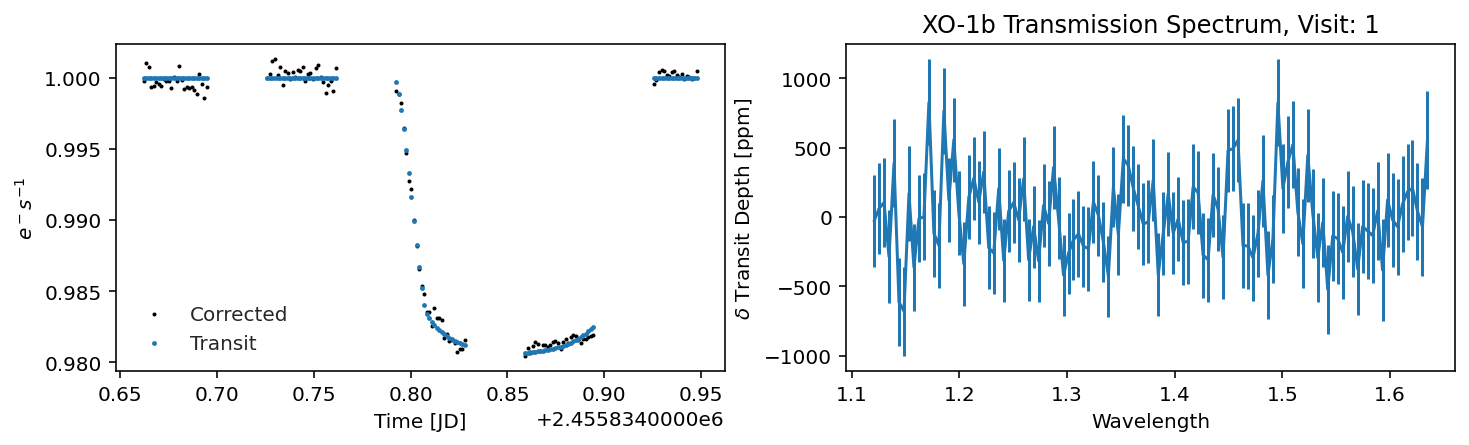

In [23]:
obs.plot_spectra();